Import of necessary libraries

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import time
import re
from transformers import RobertaTokenizer, RobertaForTokenClassification, pipeline
from sklearn.preprocessing import LabelEncoder
import torch
import warnings
import sklearn
warnings.filterwarnings('ignore')
seed = 42

Dataset clean (only once)

In [41]:
dataset= pd.read_csv("explaination_toxic_conversation_most_toxic_sentences.csv",header=0,encoding='utf-8')
dataset = dataset[dataset['explaination'].str.contains("La frase più tossica è", na=False)]
# Add a new column 'toxic' with value 1 for all rows
dataset['toxic'] = 1

non_toxic_dataset= pd.read_csv("generated_dataset.csv",header=0,encoding='utf-8')
# Concatenate the two datasets
dataset = pd.concat([dataset, non_toxic_dataset], ignore_index=False)

def validate_conversation_format(conversation):
    """
    Validates the format of a conversation string with more lenient criteria.
    """
    if pd.isna(conversation) or not isinstance(conversation, str):
        return False
    
    # Find all messages enclosed in double quotes
    message_pattern = r'"([^"]*)"'
    messages = re.findall(message_pattern, conversation)
    
    # Need at least 2 messages
    if len(messages) < 2:
        return False
    
    # Check that quotes are even numbered
    quote_count = conversation.count('"')
    if quote_count % 2 != 0:
        return False
    
    # Count valid messages (at least some content, not just empty or single chars)
    valid_messages = 0
    for msg in messages:
        cleaned_msg = msg.strip()
        if len(cleaned_msg) >= 2:  # Ridotto da 3 a 2 caratteri
            valid_messages += 1
    
    # Need at least 2 valid messages (più permissivo)
    return valid_messages >= 2

def clean_and_reconstruct_conversation(conversation):
    """
    Extract messages from conversation with more lenient cleaning.
    """
    if pd.isna(conversation) or not isinstance(conversation, str):
        return ""
    
    # Extract all messages enclosed in double quotes
    message_pattern = r'"([^"]*)"'
    messages = re.findall(message_pattern, conversation)
    
    if len(messages) < 2:
        return ""
    
    # Clean each message with more lenient criteria
    clean_messages = []
    for msg in messages:
        cleaned_msg = msg.strip()
        # Solo filtri basilari: almeno 2 caratteri e non solo spazi
        if len(cleaned_msg) >= 2 and not cleaned_msg.isspace():
            clean_messages.append(f'"{cleaned_msg}"')
    
    # Need at least 2 valid messages
    if len(clean_messages) < 2:
        return ""
    
    # Reconstruct conversation
    return " ".join(clean_messages)

print(f"Original dataset size: {len(dataset)}")

# Step 1: Initial validation and cleaning - PIU' PERMISSIVO
print("🧹 Cleaning and normalizing conversations...")
dataset = dataset.dropna(subset=['conversation'])

# Prima conta quante conversazioni ci sono
initial_count = len(dataset)
print(f"Conversations before validation: {initial_count}")

# Applica validazione più permissiva
valid_mask = dataset['conversation'].apply(validate_conversation_format)
dataset = dataset[valid_mask].copy()

print(f"Rows after format validation: {len(dataset)}")
print(f"Rows removed due to invalid format: {initial_count - len(dataset)}")

# Step 2: Clean and reconstruct conversations
print("\n🔧 Cleaning conversations...")
dataset['conversation_clean'] = dataset['conversation'].apply(clean_and_reconstruct_conversation)

# Remove rows where conversation cleaning failed
before_cleaning = len(dataset)
dataset_clean = dataset[dataset['conversation_clean'] != ""].copy()
print(f"Rows after conversation cleaning: {len(dataset_clean)}")
print(f"Rows removed due to cleaning issues: {before_cleaning - len(dataset_clean)}")

# Replace original conversation with clean version
dataset_clean['conversation'] = dataset_clean['conversation_clean']
dataset_clean = dataset_clean.drop('conversation_clean', axis=1)

# Step 3: Show examples of cleaning
print(f"\n📋 Examples of conversation normalization:")
for i in range(min(3, len(dataset_clean))):
    original = dataset.iloc[i]['conversation'] if i < len(dataset) else "N/A"
    clean = dataset_clean.iloc[i]['conversation']
    
    print(f"\nExample {i+1}:")
    print(f"Original: {original[:100]}...")
    print(f"Cleaned:  {clean[:100]}...")

# Update dataset
dataset = dataset_clean
print(f"\n🎯 Final cleaned dataset: {len(dataset)} conversations")
print(f"📊 Data retention: {len(dataset)/initial_count*100:.1f}% of original conversations kept")

# Save the cleaned dataset
dataset.to_csv("filtered_dataset.csv", index=False, encoding='utf-8')
print(f"💾 Dataset saved as 'filtered_dataset.csv'")

Original dataset size: 1475
🧹 Cleaning and normalizing conversations...
Conversations before validation: 1475
Rows after format validation: 857
Rows removed due to invalid format: 618

🔧 Cleaning conversations...
Rows after conversation cleaning: 857
Rows removed due to cleaning issues: 0

📋 Examples of conversation normalization:

Example 1:
Original: 1. "Hai assolutamente ragione. Sei così unico e speciale. Nessuno è mai stato come te. È incredibile...
Cleaned:  "Hai assolutamente ragione. Sei così unico e speciale. Nessuno è mai stato come te. È incredibile co...

Example 2:
Original: 1. Ubaldo: "Sono arrabbiata perché ti sei ubriacato e mi hai insultata davanti a tutti. Sembri compl...
Cleaned:  "Sono arrabbiata perché ti sei ubriacato e mi hai insultata davanti a tutti. Sembri completamente in...

Example 3:
Original: Renetto          "Scusa, ma non è che stai dicendo sempre la stessa cosa, no? Non sei mai felice, no...
Cleaned:  "Scusa, ma non è che stai dicendo sempre la stessa 

# BINARY CLASSIFICATION : Toxic or not #


# First Attempt: Pre-processing

In this section, we perform binary classification to determine whether a conversation is toxic or not. some pre-processing steps are applied. We apply TF-IDF vectorization directly to the conversation text and train a Logistic Regression model with hyperparameter tuning through nested cross-validation.

The model evaluates the following metrics:
- Accuracy
- F1 Score
- Precision
- Recall

The confusion matrix visualizes the model's performance in distinguishing between toxic and non-toxic conversations.

### Let's apply a pre-processing pipeline for text ###

Dataset shape: (857, 3314)
Training set shape: (599, 3314)
Test set shape: (258, 3314)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s finished



Best parameters found: {'C': 10, 'max_iter': 100, 'penalty': 'l2'}
Best cross-validation F1 score: 0.9967
Time taken for training and evaluation:: 21.73 seconds
Test Accuracy: 1.0000
Test F1-Score: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000


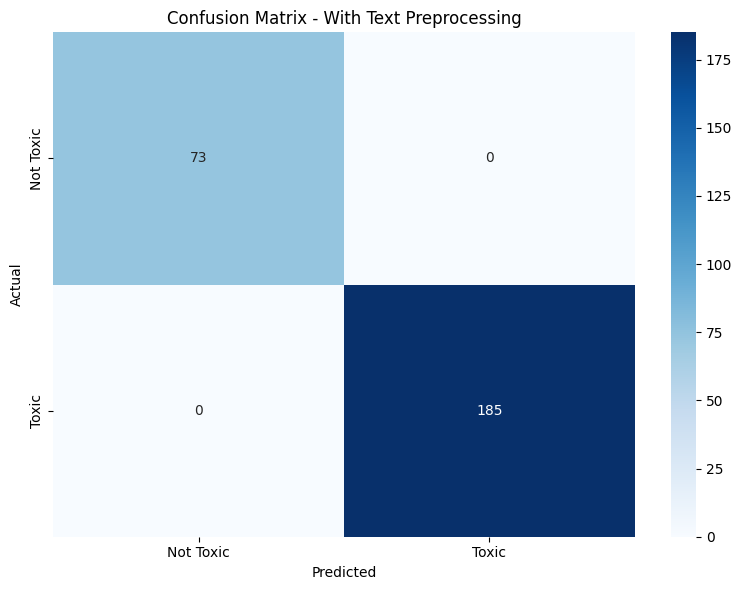

In [32]:
#load the Italian language model for spaCy
# If you haven't installed the Italian model yet, you can do so with:
# !python -m spacy download it_core_news_sm
nlp = spacy.load('it_core_news_sm')

def preprocess_italian_text(text):
    """Italian text preprocessing function that tokenizes, lemmatizes, and removes stopwords"""
    if pd.isna(text):
        return ""
    
    # Convert text to string and lowercase
    text = str(text).lower()
    
    # Process the text with spaCy. Doc is a spaCy object that contains the processed text
    doc = nlp(text)
    
    # Initialize an empty list to hold processed tokens
    processed_tokens = []
    for token in doc:
        # Check if the token is not a stop word, punctuation, space, or a number
        if (not token.is_stop and 
            not token.is_punct and 
            not token.is_space and 
            not token.like_num):
            # Append the lemmatized token to the processed tokens list
            processed_tokens.append(token.lemma_)
    
    return " ".join(processed_tokens)

dataset=pd.read_csv("filtered_dataset.csv",header=0, encoding='utf-8')
#set seed for reproducibility
sklearn.utils.check_random_state(seed)
#shuffle the dataset
dataset = dataset.sample(frac=1, random_state=seed)
X = dataset['conversation']
y = dataset['toxic']

start_time = time.time()
# Apply an italian tokenizer, lemmatizer, and stop words
X_preprocessed = X.apply(preprocess_italian_text)

#Let's apply the TF-IDF vectorizer to the conversation data
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X_preprocessed)
#Now we can split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.3, random_state=seed)

print(f"Dataset shape: {X_vectorized.shape}")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

#Let's search for the best hyperparameters for the Logistic Regression model using a Nested Cross-Validation approach
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2', 'l1'],
    'max_iter': [100, 200, 500],
}

inner_cv = 5  # 5-fold cross-validation for hyperparameter tuning
outer_cv = 5  # 5-fold cross-validation for model evaluation

# Create the model
logistic_model = LogisticRegression(random_state=seed, solver='liblinear')

# Create GridSearchCV object for inner loop
grid_search = GridSearchCV(logistic_model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1, verbose=0)

# Outer loop: cross-validation for unbiased performance estimation
nested_scores = cross_val_score(grid_search, X_train, y_train, cv=outer_cv, scoring='f1', verbose=1)

# Fit the grid search on the entire training set to get the best parameters
grid_search.fit(X_train, y_train)
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

# Now we can train the final model with the best parameters found
final_model = LogisticRegression(**grid_search.best_params_, random_state=seed, solver='liblinear')
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
end_time = time.time()
print(f"Time taken for training and evaluation:: {end_time - start_time:.2f} seconds")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Create a confusion matrix with labels

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Toxic', 'Toxic'], 
            yticklabels=['Not Toxic', 'Toxic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - With Text Preprocessing')
plt.tight_layout()
plt.show()

## What if we don't apply any pre-processing? ##

Dataset shape: (857, 4585)
Training set shape: (599, 4585)
Test set shape: (258, 4585)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished



Best parameters found: {'C': 1, 'max_iter': 100, 'penalty': 'l2'}
Best cross-validation F1 score: 0.9967
Time taken for training and evaluation: 1.05 seconds
Test Accuracy: 1.0000
Test F1-Score: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000


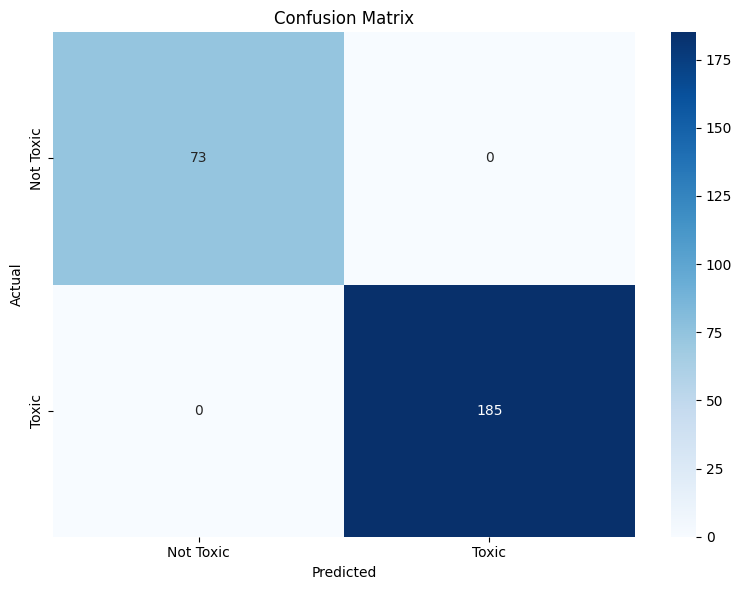

In [33]:
dataset=pd.read_csv("filtered_dataset.csv",header=0, encoding='utf-8')
#set seed for reproducibility
sklearn.utils.check_random_state(seed)
#shuffle the dataset
dataset = dataset.sample(frac=1, random_state=seed)
#take 70% of the dataset for training and 30% for testing
#X contains the conversation, y contains the toxic label
X = dataset['conversation']
y = dataset['toxic']

init_time = time.time()
#Let's apply the TF-IDF vectorizer to the conversation data
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)
#Now we can split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.3, random_state=seed)

print(f"Dataset shape: {X_vectorized.shape}")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

#Let's search for the best hyperparameters for the Logistic Regression model using a Nested Cross-Validation approach
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2', 'l1'],
    'max_iter': [100, 200, 500],
}


inner_cv = 5  # 5-fold cross-validation for hyperparameter tuning
outer_cv = 5  # 5-fold cross-validation for model evaluation

# Create the model
logistic_model = LogisticRegression(random_state=seed, solver='liblinear')

# Create GridSearchCV object for inner loop
grid_search = GridSearchCV(logistic_model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1, verbose=0)



# Outer loop: cross-validation for unbiased performance estimation
nested_scores = cross_val_score(grid_search, X_train, y_train, cv=outer_cv, scoring='f1', verbose=1)



# Fit the grid search on the entire training set to get the best parameters
grid_search.fit(X_train, y_train)
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

# Now we can train the final model with the best parameters found
final_model = LogisticRegression(**grid_search.best_params_, random_state=seed, solver='liblinear')
final_model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

final_time = time.time()
print(f"Time taken for training and evaluation: {final_time - init_time:.2f} seconds")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")




# Create a confusion matrix with labels

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Toxic', 'Toxic'], 
            yticklabels=['Not Toxic', 'Toxic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


## Conclusion ##

In this analysis, we performed binary classification to detect toxic conversations using two approaches: one without text preprocessing and one with Italian language-specific preprocessing (tokenization, lemmatization, and stopword removal).

**Key Findings:**

Both models achieved remarkably similar performance metrics:

- **Without preprocessing**: Accuracy: 100%, F1-Score: 100%, Precision: 100%, Recall: 100% (Training time: ~1 second)
- **With preprocessing**: Accuracy: 100%, F1-Score: 100%, Precision: 100%, Recall: 100% (Training time: ~22 seconds)

**Performance Analysis:**

The results demonstrate that both approaches yield virtually identical classification performance, with perfect scores across all metrics. However, there is a significant difference in computational efficiency:

- The preprocessing pipeline requires approximately **20 times more computational time** than the raw text approach
- Both models achieve perfect classification on the test set, suggesting that the dataset may be well-separated or that the features are highly discriminative

**Practical Implications:**

Given these results, the text preprocessing step appears to be unnecessary for this particular dataset and classification task. The raw text approach provides:
- Equivalent predictive performance
- Substantial computational savings
- Reduced implementation complexity
- Lower resource requirements


# Conversation TAGGING with RoBERTa #

### Let's load and clean our dataset ###

Only needed once

In [42]:
dataset=pd.read_csv("filtered_dataset.csv",header=0, index_col=-1, encoding='utf-8')
print("Number of rows in the dataset:", len(dataset))

def extract_personality_types(person_couple):
    """
    Extract the personality types from the given couple string.
    """
    personality_mapping = {
        # Personalità tossiche
        'Psicopatico e Adulatrice': ('Psicopatico', 'Adulatrice'),
        'Manipolatore e Dipendente emotiva': ('Manipolatore', 'Dipendente emotiva'),
        'Persona violenta e Succube': ('Persona violenta', 'Succube'),
        'Narcisista e Succube': ('Narcisista', 'Succube'),
        'Sadico-Crudele e Masochista': ('Sadico-Crudele', 'Masochista'),
        'Perfezionista Critico e Insicura Cronica': ('Perfezionista Critico', 'Insicura Cronica'),
        'Vittimista e Croccerossina': ('Vittimista', 'Croccerossina'),
        'Dominante e Schiavo emotivo': ('Dominante', 'Schiavo emotivo'),
        'Geloso-Ossessivo e Sottomessa': ('Geloso-Ossessivo', 'Sottomessa'),
        'Controllore e Isolata': ('Controllore', 'Isolata'),
        
        # Personalità non tossiche (nuove)
        'Preoccupato e Rassicurante': ('Preoccupato', 'Rassicurante'),
        'Entusiasta e Sostenitore': ('Entusiasta', 'Sostenitore'),
        'Affettuoso e Rispettoso': ('Affettuoso', 'Rispettoso'),
        'Tranquillo e Confortante': ('Tranquillo', 'Confortante')
    }
    
    return personality_mapping.get(person_couple, (None, None))

def create_personality_tokens(personality_type):
    """
    Create a simple token for a given personality type.
    The token is formatted as [PERSONALITY].
    """
    # Normalize personality name to create valid token
    clean_personality = personality_type.replace(' ', '_').replace('-', '_').upper()
    token = f"[{clean_personality}]"
    return token

def clean_and_reconstruct_conversation(conversation):
    """
    Extract messages from conversation and reconstruct it cleanly with only alternating quoted messages.
    """
    if pd.isna(conversation) or not isinstance(conversation, str):
        return ""
    
    # Extract all messages enclosed in double quotes
    message_pattern = r'"([^"]*)"'
    messages = re.findall(message_pattern, conversation)
    
    if len(messages) < 2:
        return ""
    
    # Clean each message and filter out empty ones
    clean_messages = []
    for msg in messages:
        cleaned_msg = msg.strip()
        if cleaned_msg:  # Only keep non-empty messages
            clean_messages.append(f'"{cleaned_msg}"')
    
    # Reconstruct conversation with clean alternating messages
    return " ".join(clean_messages)

def tag_conversation_with_personalities(conversation, person_couple):
    """
    Apply personality tagging to a conversation based on the given person_couple.
    Returns None if tagging fails to ensure data consistency.
    """
    # Extract personality types
    personality1, personality2 = extract_personality_types(person_couple)
    
    if personality1 is None or personality2 is None:
        return None  # Return None instead of original conversation
    
    # Create tokens for both personalities
    token1 = create_personality_tokens(personality1)
    token2 = create_personality_tokens(personality2)
    
    # Extract all messages from conversation
    message_pattern = r'"([^"]*)"'
    messages = re.findall(message_pattern, conversation)
    
    if len(messages) < 2:
        return None  # Return None if not enough messages
    
    # Build tagged conversation
    tagged_messages = []
    
    for i, message in enumerate(messages):
        message = message.strip()
        
        # Alternate between personalities (0,2,4... = personality1; 1,3,5... = personality2)
        if i % 2 == 0:
            # Message from first personality - TAG ALLA FINE
            tagged_message = f"{message} {token1}"
        else:
            # Message from second personality - TAG ALLA FINE
            tagged_message = f"{message} {token2}"
        
        tagged_messages.append(tagged_message)
    
    return " ".join(tagged_messages)


print(f"Original rows: {len(dataset)}")
print(f"Rows after initial cleaning: {len(dataset)}")
print(f"Rows removed: {len(dataset) - len(dataset)}")

# Step 2: Check personality couple mapping
print(f"\n🔍 Checking personality couple mapping...")
unique_couples = dataset['person_couple'].unique()
unmapped_couples = []

for couple in unique_couples:
    personality1, personality2 = extract_personality_types(couple)
    if personality1 is None or personality2 is None:
        unmapped_couples.append(couple)

if unmapped_couples:
    print(f"❌ Found {len(unmapped_couples)} unmapped personality couples:")
    for couple in unmapped_couples:
        print(f"   - {couple}")
    print("These will be excluded from the final dataset!")
else:
    print(f"✅ All {len(unique_couples)} personality couples are properly mapped")

# Show distribution of personality couples
print(f"\n📊 Personality couple distribution:")
couple_counts = dataset['person_couple'].value_counts()
for couple, count in couple_counts.items():
    print(f"   - {couple}: {count} conversations")

# Step 3: Clean and reconstruct conversations
print(f"\n🔧 Cleaning and reconstructing conversations...")
dataset['conversation_clean'] = dataset['conversation'].apply(clean_and_reconstruct_conversation)

# Remove rows where conversation cleaning failed
before_conv_cleaning = len(dataset)
dataset = dataset[dataset['conversation_clean'] != ""].copy()
print(f"Rows after conversation cleaning: {len(dataset)}")
print(f"Rows removed due to conversation issues: {before_conv_cleaning - len(dataset)}")

# Replace original conversation with clean version
dataset['conversation'] = dataset['conversation_clean']
dataset = dataset.drop('conversation_clean', axis=1)

# Step 4: Apply personality tagging
print(f"\n🏷️ Adding personality tokens...")
dataset['tagged_conversation'] = dataset.apply(
    lambda row: tag_conversation_with_personalities(row['conversation'], row['person_couple']), 
    axis=1
)

# Step 5: Filter out failed tagging
before_tagging_filter = len(dataset)
dataset_final = dataset[dataset['tagged_conversation'].notna()].copy()
print(f"Rows after filtering failed tagging: {len(dataset_final)}")
print(f"Rows removed due to tagging failures: {before_tagging_filter - len(dataset_final)}")

# Step 6: Quality check and examples
if len(dataset_final) > 0:
    print(f"\n✅ Example of cleaned and tagged conversation:")
    sample_row = dataset_final.iloc[0]
    print(f"Couple: {sample_row['person_couple']}")
    print(f"Clean conversation: {sample_row['conversation'][:150]}...")
    print(f"Tagged conversation: {sample_row['tagged_conversation'][:200]}...")
    
    # Show token verification - AGGIORNATO
    print(f"\n🔍 Token verification for first conversation:")
    tokens_found = re.findall(r'\[[A-Z_]+\]', sample_row['tagged_conversation'])
    print(f"Tokens found: {tokens_found[:6]}...")  # Show first 6 tokens
else:
    print("❌ No valid conversations after processing!")

# Step 7: Final dataset preparation
dataset = dataset_final
print(f"\n🎯- Total conversations: {len(dataset)}")

# Keep only the required columns
dataset = dataset[['conversation', 'tagged_conversation']]

# Step 8: Save dataset
dataset.to_csv("dataset_clean_with_personality_tags.csv", index=False, encoding='utf-8')
print(f"💾 Dataset saved as 'dataset_clean_with_personality_tags.csv'")

Number of rows in the dataset: 857
Original rows: 857
Rows after initial cleaning: 857
Rows removed: 0

🔍 Checking personality couple mapping...
✅ All 14 personality couples are properly mapped

📊 Personality couple distribution:
   - Geloso-Ossessivo e Sottomessa: 86 conversations
   - Affettuoso e Rispettoso: 78 conversations
   - Manipolatore e Dipendente emotiva: 73 conversations
   - Sadico-Crudele e Masochista: 69 conversations
   - Perfezionista Critico e Insicura Cronica: 68 conversations
   - Tranquillo e Confortante: 66 conversations
   - Preoccupato e Rassicurante: 65 conversations
   - Vittimista e Croccerossina: 64 conversations
   - Narcisista e Succube: 57 conversations
   - Entusiasta e Sostenitore: 55 conversations
   - Persona violenta e Succube: 50 conversations
   - Psicopatico e Adulatrice: 45 conversations
   - Controllore e Isolata: 44 conversations
   - Dominante e Schiavo emotivo: 37 conversations

🔧 Cleaning and reconstructing conversations...
Rows after conve

# Now let's use RoBERTa #

In [39]:
# Load dataset with personality tags
dataset = pd.read_csv("dataset_clean_with_personality_tags.csv", header=0, encoding='utf-8')

def extract_all_personalities_from_conversation(tagged_conversation):
    """Extract all personalities present in a tagged conversation"""
    if pd.isna(tagged_conversation):
        return []
    
    pattern = r'\[START_([A-Z_]+)\]'
    matches = re.findall(pattern, tagged_conversation)
    
    personalities = []
    for personality in matches:
        clean_personality = personality.replace('_', ' ').title()
        personalities.append(clean_personality)
    
    return list(set(personalities))  # Remove duplicates

def prepare_multi_label_dataset(dataset):
    """Prepare dataset for multi-label classification"""
    data = []
    
    for idx, row in dataset.iterrows():
        conversation = row['conversation']
        personalities = extract_all_personalities_from_conversation(row['tagged_conversation'])
        
        if conversation and personalities:
            data.append({
                'conversation': conversation,
                'personalities': personalities
            })
    
    return data

def predict_conversation_personalities(conversation, classifier):
    """Predict all personalities in a conversation using zero-shot classification"""
    candidate_labels = [
        "Psicopatico", "Adulatrice", "Manipolatore", "Dipendente Emotiva",
        "Persona Violenta", "Succube", "Narcisista", "Perfezionista Critico", 
        "Insicura Cronica", "Vittimista", "Croccerossina", "Dominante",
        "Schiavo Emotivo", "Geloso Ossessivo", "Sottomessa", "Controllore", "Isolata"
    ]
    
    try:
        result = classifier(conversation, candidate_labels, multi_label=True)
        
        # Filter predictions with confidence > threshold
        threshold = 0.3
        predicted_personalities = [
            label for label, score in zip(result['labels'], result['scores']) 
            if score > threshold
        ]
        
        return predicted_personalities
    except Exception as e:
        return []

def calculate_multi_label_metrics(y_true, y_pred):
    """Calculate metrics for multi-label classification"""
    from sklearn.preprocessing import MultiLabelBinarizer
    
    # Convert to binary format
    mlb = MultiLabelBinarizer()
    
    # Fit on all possible labels
    all_labels = set()
    for labels in y_true + y_pred:
        all_labels.update(labels)
    
    mlb.fit([list(all_labels)])
    
    y_true_bin = mlb.transform(y_true)
    y_pred_bin = mlb.transform(y_pred)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_bin, y_pred_bin)
    f1_micro = f1_score(y_true_bin, y_pred_bin, average='micro', zero_division=0)
    f1_macro = f1_score(y_true_bin, y_pred_bin, average='macro', zero_division=0)
    precision_micro = precision_score(y_true_bin, y_pred_bin, average='micro', zero_division=0)
    recall_micro = recall_score(y_true_bin, y_pred_bin, average='micro', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro
    }

# Prepare the dataset
print("🔄 Preparing multi-label dataset...")
data = prepare_multi_label_dataset(dataset)

# Split into train and test
train_data, test_data = train_test_split(data, test_size=0.3, random_state=seed)

print(f"📊 Dataset split:")
print(f"   Training samples: {len(train_data)}")
print(f"   Test samples: {len(test_data)}")

# Initialize classifier
print("🤖 Initializing RoBERTa classifier...")
classifier = pipeline("zero-shot-classification", 
                     model="facebook/bart-large-mnli",
                     tokenizer="facebook/bart-large-mnli")

# Test on subset for performance
test_subset = test_data[:30]  # Test on 30 samples

print("🚀 Running predictions on test set...")
start_time = time.time()

y_true = []
y_pred = []

for i, sample in enumerate(test_subset):
    conversation = sample['conversation']
    true_personalities = sample['personalities']
    
    predicted_personalities = predict_conversation_personalities(conversation, classifier)
    
    y_true.append(true_personalities)
    y_pred.append(predicted_personalities)
    
    if (i + 1) % 10 == 0:
        print(f"   Processed {i+1}/{len(test_subset)} samples")

prediction_time = time.time() - start_time

# Calculate metrics
metrics = calculate_multi_label_metrics(y_true, y_pred)

# Calculate baseline (always predict most frequent personality)
all_personalities = []
for labels in y_true:
    all_personalities.extend(labels)

from collections import Counter
most_frequent = Counter(all_personalities).most_common(1)[0][0]
baseline_pred = [[most_frequent] for _ in y_true]
baseline_metrics = calculate_multi_label_metrics(y_true, baseline_pred)

print(f"\n📈 ROBERTA MULTI-LABEL PERFORMANCE:")
print(f"   🎯 Accuracy: {metrics['accuracy']:.4f}")
print(f"   📊 F1-Score (Micro): {metrics['f1_micro']:.4f}")
print(f"   📊 F1-Score (Macro): {metrics['f1_macro']:.4f}")
print(f"   📊 Precision (Micro): {metrics['precision_micro']:.4f}")
print(f"   📊 Recall (Micro): {metrics['recall_micro']:.4f}")
print(f"   ⏱️ Time: {prediction_time:.2f}s")
print(f"   📈 Baseline F1-Micro: {baseline_metrics['f1_micro']:.4f}")
print(f"   📈 Improvement: {(metrics['f1_micro'] - baseline_metrics['f1_micro']):.4f}")

# Show some examples
print(f"\n🔍 Example predictions:")
for i in range(min(3, len(y_true))):
    true_set = set(y_true[i])
    pred_set = set(y_pred[i])
    
    intersection = true_set.intersection(pred_set)
    
    print(f"\nExample {i+1}:")
    print(f"   True: {sorted(y_true[i])}")
    print(f"   Predicted: {sorted(y_pred[i])}")
    print(f"   Correct: {len(intersection)}/{len(true_set)}")

# Visualize personality distribution
from collections import Counter
true_counts = Counter()
pred_counts = Counter()

for labels in y_true:
    true_counts.update(labels)
for labels in y_pred:
    pred_counts.update(labels)

personalities = sorted(list(set(list(true_counts.keys()) + list(pred_counts.keys()))))
true_vals = [true_counts.get(p, 0) for p in personalities]
pred_vals = [pred_counts.get(p, 0) for p in personalities]

x = range(len(personalities))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar([i - width/2 for i in x], true_vals, width, label='True', alpha=0.8, color='skyblue')
ax.bar([i + width/2 for i in x], pred_vals, width, label='Predicted', alpha=0.8, color='orange')

ax.set_xlabel('Personality Types')
ax.set_ylabel('Frequency')
ax.set_title('Personality Distribution: True vs Predicted')
ax.set_xticks(x)
ax.set_xticklabels(personalities, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

🔄 Preparing multi-label dataset...


ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.